Load dataset

In [125]:
import json

bos = "<BOS>"
eos = "<EOS>"
MAX_TARGET_SIZE = 62
MAX_INTPUT_DATA_SIZE = 40000

input_data = []
target_data = []
for line in open('train_shuffled.json', 'r', encoding='utf-8'):
    example = json.loads(line)
    
    input_data.append(example["code"])
    target_data.append([bos] + list(map(lambda word: word.lower(), example["nlToks"][:MAX_TARGET_SIZE])) + [eos])

    MAX_INTPUT_DATA_SIZE -= 1
    if MAX_INTPUT_DATA_SIZE == 0:
        break

In [126]:
#import json
#dataset = tf.data.TextLineDataset(["train_shuffled.json"])

In [127]:
print(len(input_data))
print(input_data[23])
print(target_data[23])

40000
['boolean', 'function', '(', ')', '{', 'return', 'globalAdminRole', ';', '}']
['<BOS>', 'get', 'if', 'has', 'global', 'admin', 'role', '.', '<EOS>']


Create a vocabulary to save mappings from tokens to integer indices

In [128]:
input_vocab = set()
target_vocab = set()

for line in input_data:
    input_vocab.update(line)

for line in target_data:
    target_vocab.update(line)

input_vocab_size = len(input_vocab)+1
target_vocab_size = len(target_vocab)+3

print(input_vocab_size)
print(target_vocab_size)

57568
23869


Learn Word2Vec mapping

In [129]:
# the '+1' is to keep the '0' reserved for padding
input_2_index = {word : counter+1 for counter, word in enumerate(input_vocab)}
index_2_input = {counter+1 : word for counter, word in enumerate(input_vocab)}

target_2_index = {word : counter+1 for counter, word in enumerate(target_vocab)}
index_2_target = {counter+1 : word for counter, word in enumerate(target_vocab)}

input_2_index["<PAD>"] = 0
target_2_index["<PAD>"] = 0
index_2_input[0] = "<PAD>"
index_2_target[0] = "<PAD>"

max_input = max(input_data, key=lambda row: len(row))
print(max_input)
max_input_size = len(max_input)

max_target = max(target_data, key=lambda row: len(row))
print(max_target)
max_target_size = len(max_target)

max_input_size, max_target_size

['int', 'function', '(', 'byte', '[', ']', 'in', ',', 'int', 'inOff', ',', 'byte', '[', ']', 'out', ',', 'int', 'outOff', ')', '{', 'int', 'A', '=', 'bytesToWord', '(', 'in', ',', 'inOff', ')', '+', '_S', '[', '0', ']', ';', 'int', 'B', '=', 'bytesToWord', '(', 'in', ',', 'inOff', '+', '4', ')', '+', '_S', '[', '1', ']', ';', 'for', '(', 'int', 'i', '=', '1', ';', 'i', '<=', '_noRounds', ';', 'i', '++', ')', '{', 'A', '=', 'rotateLeft', '(', 'A', '^', 'B', ',', 'B', ')', '+', '_S', '[', '2', '*', 'i', ']', ';', 'B', '=', 'rotateLeft', '(', 'B', '^', 'A', ',', 'A', ')', '+', '_S', '[', '2', '*', 'i', '+', '1', ']', ';', '}', 'wordToBytes', '(', 'A', ',', 'out', ',', 'outOff', ')', ';', 'wordToBytes', '(', 'B', ',', 'out', ',', 'outOff', '+', '4', ')', ';', 'return', '2', '*', '4', ';', '}']
['<BOS>', 'do', "n't", 'use', 'this', '.', 'no', ',', 'really', ',', 'do', "n't", 'use', 'this', '.', 'you', 'already', 'have', 'an', '-lcb-', '@link', 'authenticationtoken', '-rcb-', 'with', '-lcb-'

(132, 64)

In [130]:
print(input_2_index["for"])
print(index_2_input[4438])
print(target_2_index["get"])
print(index_2_target[6894])

50333
getDetailHTML
822
amounts


Converting words to padded sequences of indexes

In [131]:
input_seq = []
for row in input_data:
    seq = [input_2_index[word] for word in row]
    padding = max_input_size - len(seq)
    if padding != 0:
        seq += [0 for _ in range(padding)]
    input_seq.append(seq)

print(input_seq[23])
print(list(map(lambda idx: index_2_input[idx], input_seq[23])))

target_seq = []
for row in target_data:
    seq = [target_2_index[word] for word in row]
    padding = max_target_size - len(seq)
    if padding != 0:
        seq += [0 for _ in range(padding)]
    target_seq.append(seq)

print(target_seq[23])
print(list(map(lambda idx: index_2_target[idx], target_seq[23])))

[48369, 41127, 16913, 52514, 7185, 55254, 2911, 29597, 30542, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['boolean', 'function', '(', ')', '{', 'return', 'globalAdminRole', ';', '}', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD

Create Dataset

In [132]:
import tensorflow as tf

train_data_size = int(len(input_seq)*8/10)
valid_data_size = int(len(input_seq)*2/10)
# Configuration 
BUFFER_SIZE = len(input_seq)
BATCH_SIZE = 64
steps_per_epoch = train_data_size//BATCH_SIZE
steps_per_epoch_val = valid_data_size//BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((input_seq[:train_data_size], target_seq[:train_data_size])).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((input_seq[train_data_size:], target_seq[train_data_size:])).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 132]), TensorShape([64, 64]))

Build Model

In [133]:
from tensorflow.keras import layers

EMBEDDING_SIZE = 256 #
UNITS_SIZE = 512  # dimensionality of the output space of RNN

In [134]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,  # Whether to return the last output in the output sequence, or the full sequence. 
                                   return_state=True,  # Whether to return the last state in addition to the output.
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [135]:
example_embedding = tf.keras.layers.Embedding(target_vocab_size, EMBEDDING_SIZE)
example_embedding(tf.convert_to_tensor(target_seq[23]))

<tf.Tensor: shape=(64, 256), dtype=float32, numpy=
array([[-0.03459042, -0.04496901, -0.0122651 , ...,  0.01420889,
         0.01322491, -0.02345773],
       [ 0.01918257,  0.01337619, -0.02534912, ...,  0.02573087,
         0.04872001,  0.02911207],
       [ 0.02363515, -0.04627422,  0.01053309, ...,  0.02489039,
        -0.03361249, -0.03203248],
       ...,
       [ 0.02373663,  0.04936507, -0.03538222, ...,  0.02540287,
         0.00547739,  0.03916056],
       [ 0.02373663,  0.04936507, -0.03538222, ...,  0.02540287,
         0.00547739,  0.03916056],
       [ 0.02373663,  0.04936507, -0.03538222, ...,  0.02540287,
         0.00547739,  0.03916056]], dtype=float32)>

The decoder uses attention to selectively focus on parts of the input sequence.

In [136]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [137]:
class DecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_layer = None):
    super(DecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = attention_layer

  def call(self, x, hidden, enc_output):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    attention_weights = None
    
    if self.attention:
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)
      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

Training

In [138]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) 
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [139]:
optimizer = tf.keras.optimizers.Adam()

def get_train_step_func():

  @tf.function
  def train_step(inp, targ, enc_hidden, encoder, decoder):
    loss = 0

    with tf.GradientTape() as tape: # for automatic differentiation
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden
      
      dec_input = tf.expand_dims([target_2_index[bos]] * BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss
    
  return train_step

In [140]:
def caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
  loss = 0
  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_2_index[bos]] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  loss = loss / int(targ.shape[1])
  return loss

In [141]:
import time

def training_seq2seq(epochs, attention):
  encoder = Encoder(input_vocab_size, EMBEDDING_SIZE, UNITS_SIZE, BATCH_SIZE)
  decoder = DecoderWithAttention(target_vocab_size, EMBEDDING_SIZE, UNITS_SIZE, BATCH_SIZE, attention)
  train_step_func = get_train_step_func()
  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))
        
    enc_hidden = encoder.initialize_hidden_state()
    total_val_loss = 0
    for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch)):
      val_loss = caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
      total_val_loss += val_loss

    training_loss.append(total_loss / steps_per_epoch)
    validation_loss.append(total_val_loss / steps_per_epoch_val)
    print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                        training_loss[-1], validation_loss[-1]))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  return encoder, decoder, training_loss, validation_loss

In [155]:
epochs_a = 10
attention = BahdanauAttention(UNITS_SIZE)

print("Running seq2seq model with attention")
encoder_a, decoder_a, training_loss_a, validation_loss_a = training_seq2seq(epochs_a, attention)

Running seq2seq model with attention
Epoch 1 Batch 0 Loss 2.1608
Epoch 1 Batch 100 Loss 1.4202
Epoch 1 Batch 200 Loss 1.0806
Epoch 1 Batch 300 Loss 1.3158
Epoch 1 Batch 400 Loss 1.3707
Epoch 1 Loss 1.4742 Validation Loss 1.3480
Time taken for 1 epoch 365.12645387649536 sec

Epoch 2 Batch 0 Loss 1.4943
Epoch 2 Batch 100 Loss 1.5548
Epoch 2 Batch 200 Loss 1.4181
Epoch 2 Batch 300 Loss 1.2578
Epoch 2 Batch 400 Loss 1.2847
Epoch 2 Loss 1.2736 Validation Loss 1.2751
Time taken for 1 epoch 340.6719765663147 sec

Epoch 3 Batch 0 Loss 1.1140
Epoch 3 Batch 100 Loss 1.2273
Epoch 3 Batch 200 Loss 1.1413
Epoch 3 Batch 300 Loss 1.1030
Epoch 3 Batch 400 Loss 1.1821
Epoch 3 Loss 1.1864 Validation Loss 1.2020
Time taken for 1 epoch 344.53237748146057 sec

Epoch 4 Batch 0 Loss 1.2447
Epoch 4 Batch 100 Loss 1.4464
Epoch 4 Batch 200 Loss 1.1243
Epoch 4 Batch 300 Loss 0.9883
Epoch 4 Batch 400 Loss 1.1021
Epoch 4 Loss 1.0911 Validation Loss 1.1374
Time taken for 1 epoch 337.1328775882721 sec

Epoch 5 Batch

In [150]:
epochs = 10
attention = None

print("Running seq2seq model without attention")
encoder, decoder, training_loss, validation_loss = training_seq2seq(epochs, attention)

Running seq2seq model without attention
Epoch 1 Batch 0 Loss 2.3232
Epoch 1 Batch 100 Loss 1.5912
Epoch 1 Batch 200 Loss 1.2057
Epoch 1 Batch 300 Loss 1.0078
Epoch 1 Batch 400 Loss 1.1885
Epoch 1 Loss 1.1861 Validation Loss 1.0127
Time taken for 1 epoch 226.2422878742218 sec

Epoch 2 Batch 0 Loss 0.9228
Epoch 2 Batch 100 Loss 0.8040
Epoch 2 Batch 200 Loss 0.8031
Epoch 2 Batch 300 Loss 0.8772
Epoch 2 Batch 400 Loss 0.8189
Epoch 2 Loss 0.9099 Validation Loss 0.9393
Time taken for 1 epoch 202.4939522743225 sec

Epoch 3 Batch 0 Loss 0.8330
Epoch 3 Batch 100 Loss 0.7056
Epoch 3 Batch 200 Loss 0.7121
Epoch 3 Batch 300 Loss 0.8738
Epoch 3 Batch 400 Loss 0.8063
Epoch 3 Loss 0.7757 Validation Loss 0.9077
Time taken for 1 epoch 210.5242235660553 sec

Epoch 4 Batch 0 Loss 0.5934
Epoch 4 Batch 100 Loss 0.5890
Epoch 4 Batch 200 Loss 0.6481
Epoch 4 Batch 300 Loss 0.8136
Epoch 4 Batch 400 Loss 0.7968
Epoch 4 Loss 0.6706 Validation Loss 0.8939
Time taken for 1 epoch 207.5815577507019 sec

Epoch 5 Batc

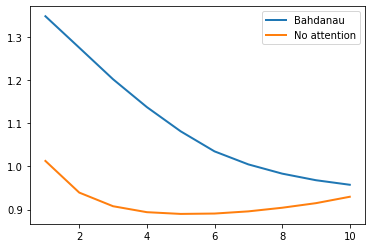

In [157]:
import matplotlib.pyplot as plt
t_a = np.arange(1, epochs_a+1)
t = np.arange(1, epochs+1)
plt.plot(t_a, validation_loss_a, lw=2)
plt.plot(t, validation_loss, lw=2)
plt.legend(('Bahdanau', 'No attention'))

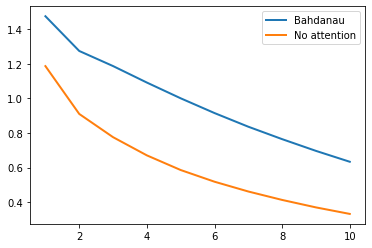

In [158]:
t_a = np.arange(1, epochs_a+1)
t = np.arange(1, epochs+1)
plt.plot(t_a, training_loss_a, lw=2)
plt.plot(t, training_loss, lw=2)
plt.legend(('Bahdanau', 'No attention'))

In [161]:
import numpy as np
def translate(code_words, encoder, decoder):
  print (code_words.split())
  
  code_tokens = [input_2_index[word] for word in code_words.split()]
  padding = max_input_size - len(code_tokens)
  if padding != 0:
      code_tokens += [0 for _ in range(padding)]

  print (code_tokens)
  code_tensor = tf.convert_to_tensor([code_tokens])

  result = ''

  hidden = tf.zeros((1, UNITS_SIZE))
  enc_out, enc_hidden = encoder(code_tensor, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_2_index[bos]], 0)

  for t in range(MAX_TARGET_SIZE):
    predictions, dec_hidden, _ = decoder(
      dec_input,
      dec_hidden,
      enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += index_2_target[predicted_id] + ' '

    # until the predicted word is <end>.
    if index_2_target[predicted_id] == eos:
      return result

    # the predicted ID is fed back into the model, no teacher forcing.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result

print(translate(
"""int count ( int number )
 {
 int sum = 0 ;
 for ( int i = 3 ; i < number ; i ++ ) {
 if ( i % 3 == 0 )
 { sum += i ; }
 }
 return sum ;
 }""",
 encoder,
 decoder))

['int', 'count', '(', 'int', 'number', ')', '{', 'int', 'sum', '=', '0', ';', 'for', '(', 'int', 'i', '=', '3', ';', 'i', '<', 'number', ';', 'i', '++', ')', '{', 'if', '(', 'i', '%', '3', '==', '0', ')', '{', 'sum', '+=', 'i', ';', '}', '}', 'return', 'sum', ';', '}']
[53943, 28136, 16913, 53943, 43856, 52514, 7185, 53943, 7054, 7501, 43991, 29597, 50333, 16913, 53943, 34155, 7501, 16627, 29597, 34155, 35125, 43856, 29597, 34155, 15902, 52514, 7185, 15553, 16913, 34155, 20351, 16627, 11001, 43991, 52514, 7185, 7054, 11484, 34155, 29597, 30542, 30542, 55254, 7054, 29597, 30542, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
computes the logarithm of the first row in the matrix <EOS> 


In [162]:
print(translate(
"""int count ( int number )
 {
 int sum = 0 ;
 for ( int i = 3 ; i < number ; i ++ ) {
 if ( i % 3 == 0 )
 { sum += i ; }
 }
 return sum ;
 }""",
 encoder_a,
 decoder_a))

['int', 'count', '(', 'int', 'number', ')', '{', 'int', 'sum', '=', '0', ';', 'for', '(', 'int', 'i', '=', '3', ';', 'i', '<', 'number', ';', 'i', '++', ')', '{', 'if', '(', 'i', '%', '3', '==', '0', ')', '{', 'sum', '+=', 'i', ';', '}', '}', 'return', 'sum', ';', '}']
[53943, 28136, 16913, 53943, 43856, 52514, 7185, 53943, 7054, 7501, 43991, 29597, 50333, 16913, 53943, 34155, 7501, 16627, 29597, 34155, 35125, 43856, 29597, 34155, 15902, 52514, 7185, 15553, 16913, 34155, 20351, 16627, 11001, 43991, 52514, 7185, 7054, 11484, 34155, 29597, 30542, 30542, 55254, 7054, 29597, 30542, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
returns the number of bits in the given index . <EOS> 
